In [2]:
# Some standard import statements that are nice for Jupyter

# this is necessary for the functions.py file to be imported
# replace the path with the appropriate path to your workspace
import sys
sys.path.append('/ucn/orithyia_data/psi_transmission/scripts')
sys.path.append('/Users/jonahbd/psi_transmission/scripts')


import os
import logging
import ipynb
import decimal
import time
import uncertainties
import datetime as dt
from lmfit import Model
import matplotlib.dates as mdates
from uncertainties import *
import numpy as np
from scipy.optimize import curve_fit
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# prevents the need to reload the kernel everytime functions.py file is updated
%load_ext autoreload
%autoreload 2

# # for plotting
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# %matplotlib ipympl
# plt.rcParams['figure.dpi'] = 600
# plt.rcParams.update({'font.size': 14})
# plt.rcParams['figure.figsize'] = (6.66, 4)

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

# importing functions for analysis
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# loading the data sets

# main detector
data_dict, norm_dict = load_all_main(raw_unix_time_flag = True)

# Time Constant of Detection Peak Tail

To determine the diffuse reflection probability the time constant of the exponential decay that occurs following the main detection peak, must be fitted. In the plots below we see the precise region of the time-of-flight spectrum that must be analyzed.

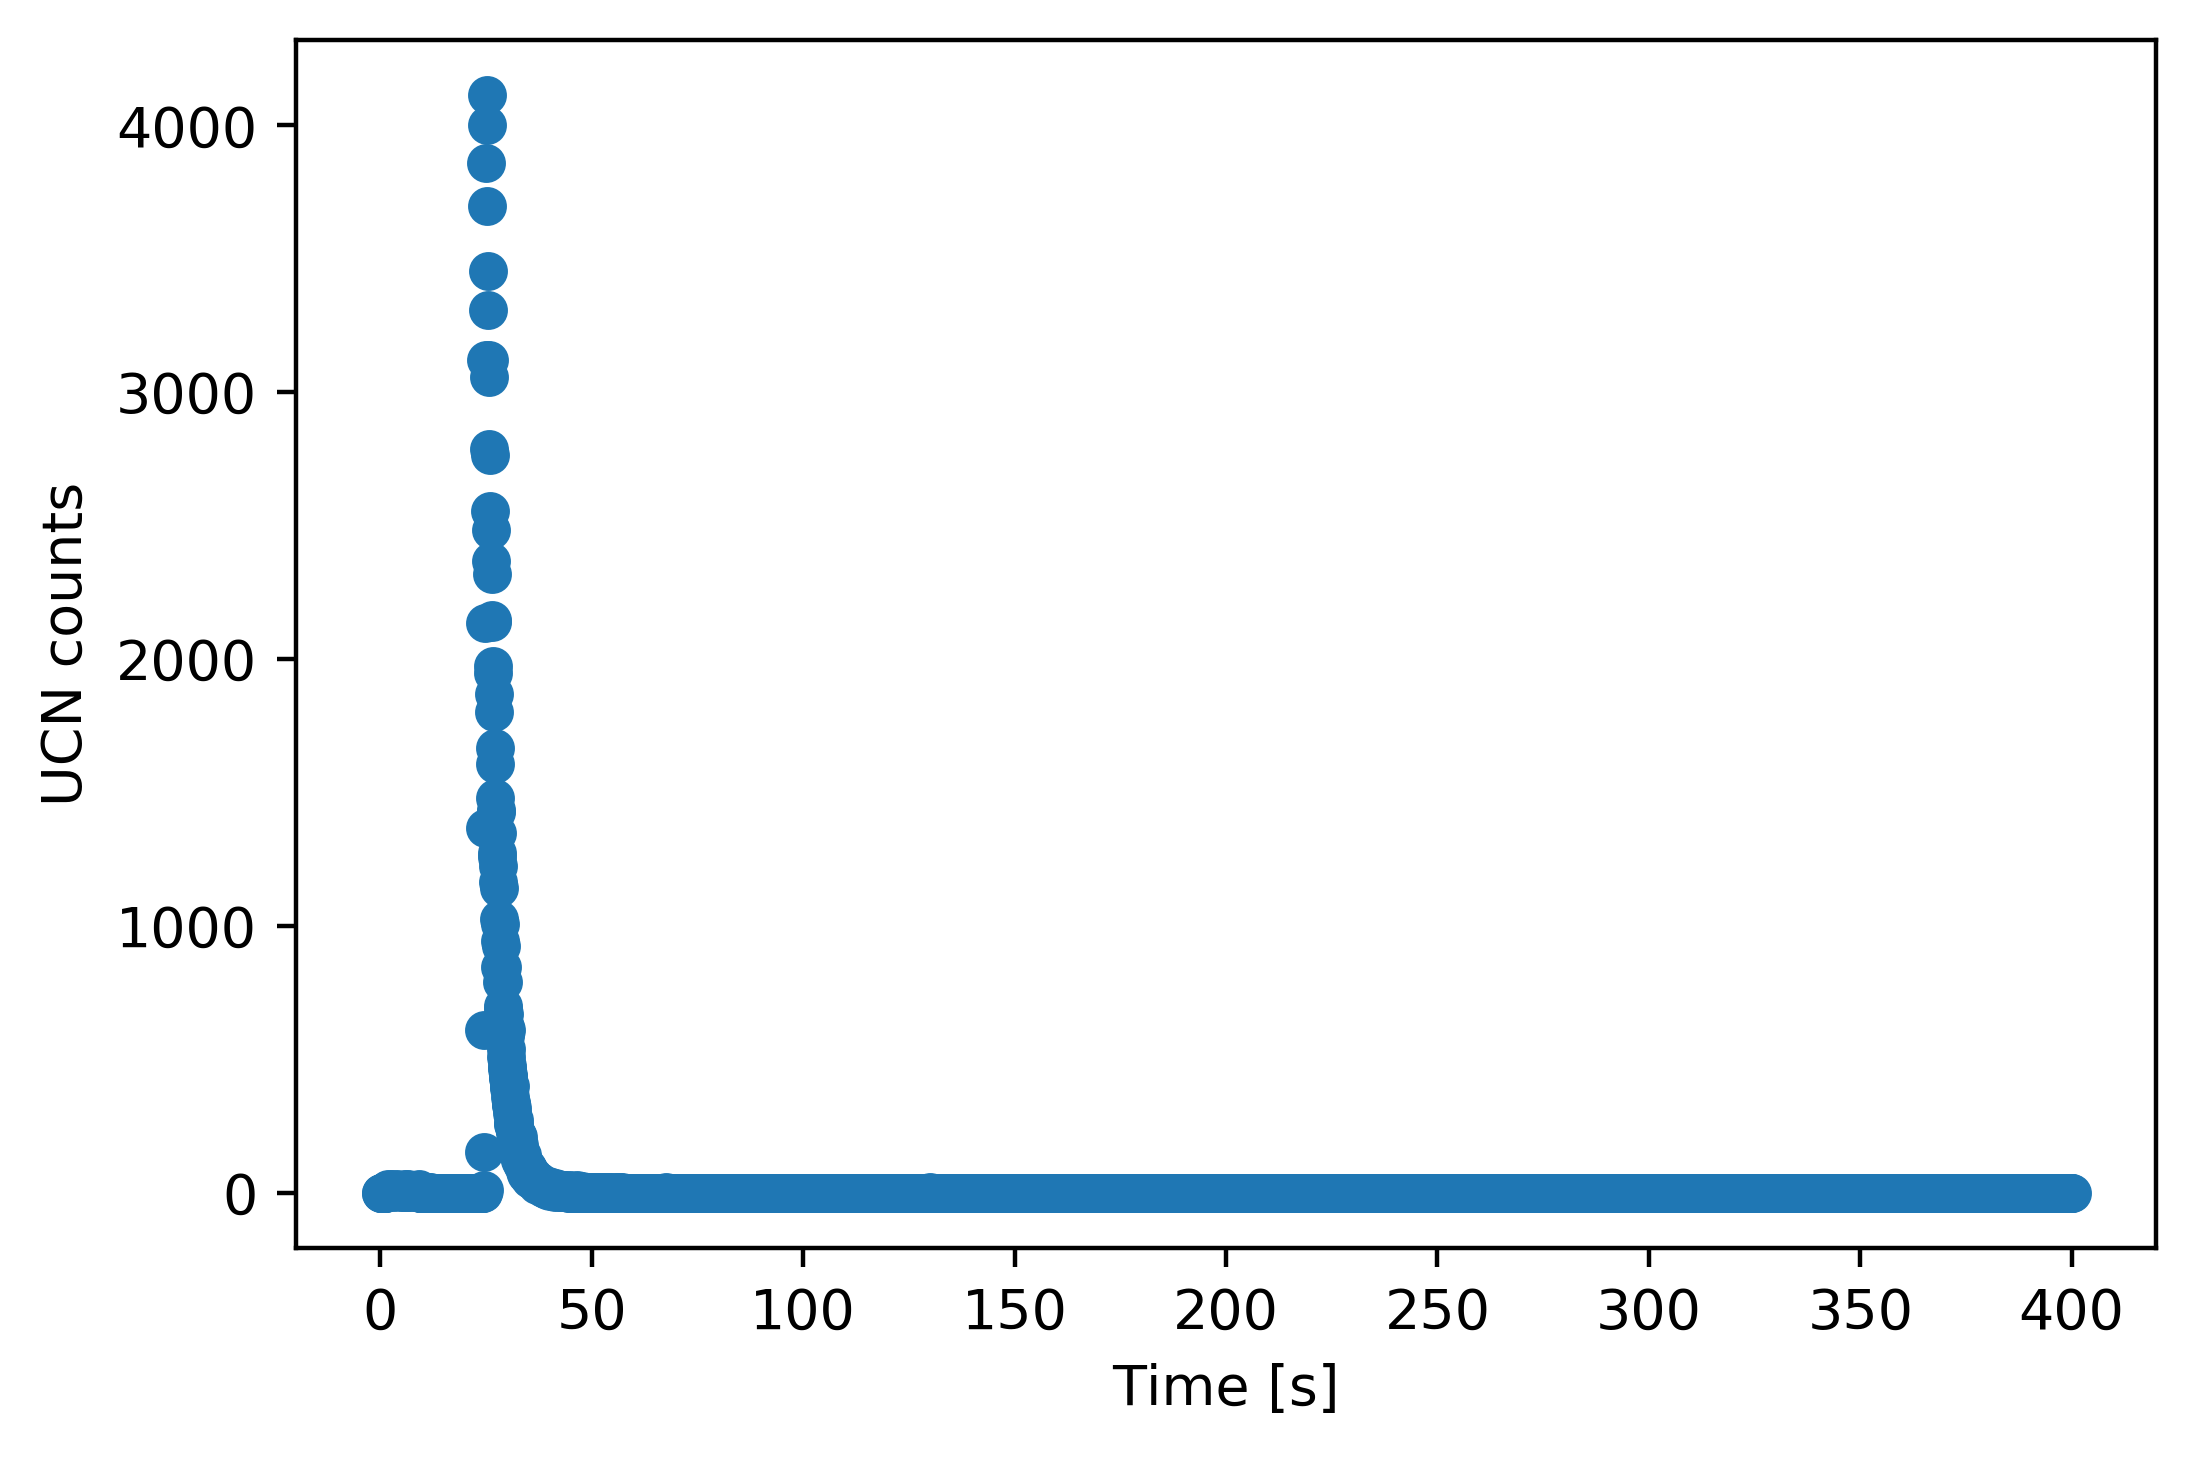

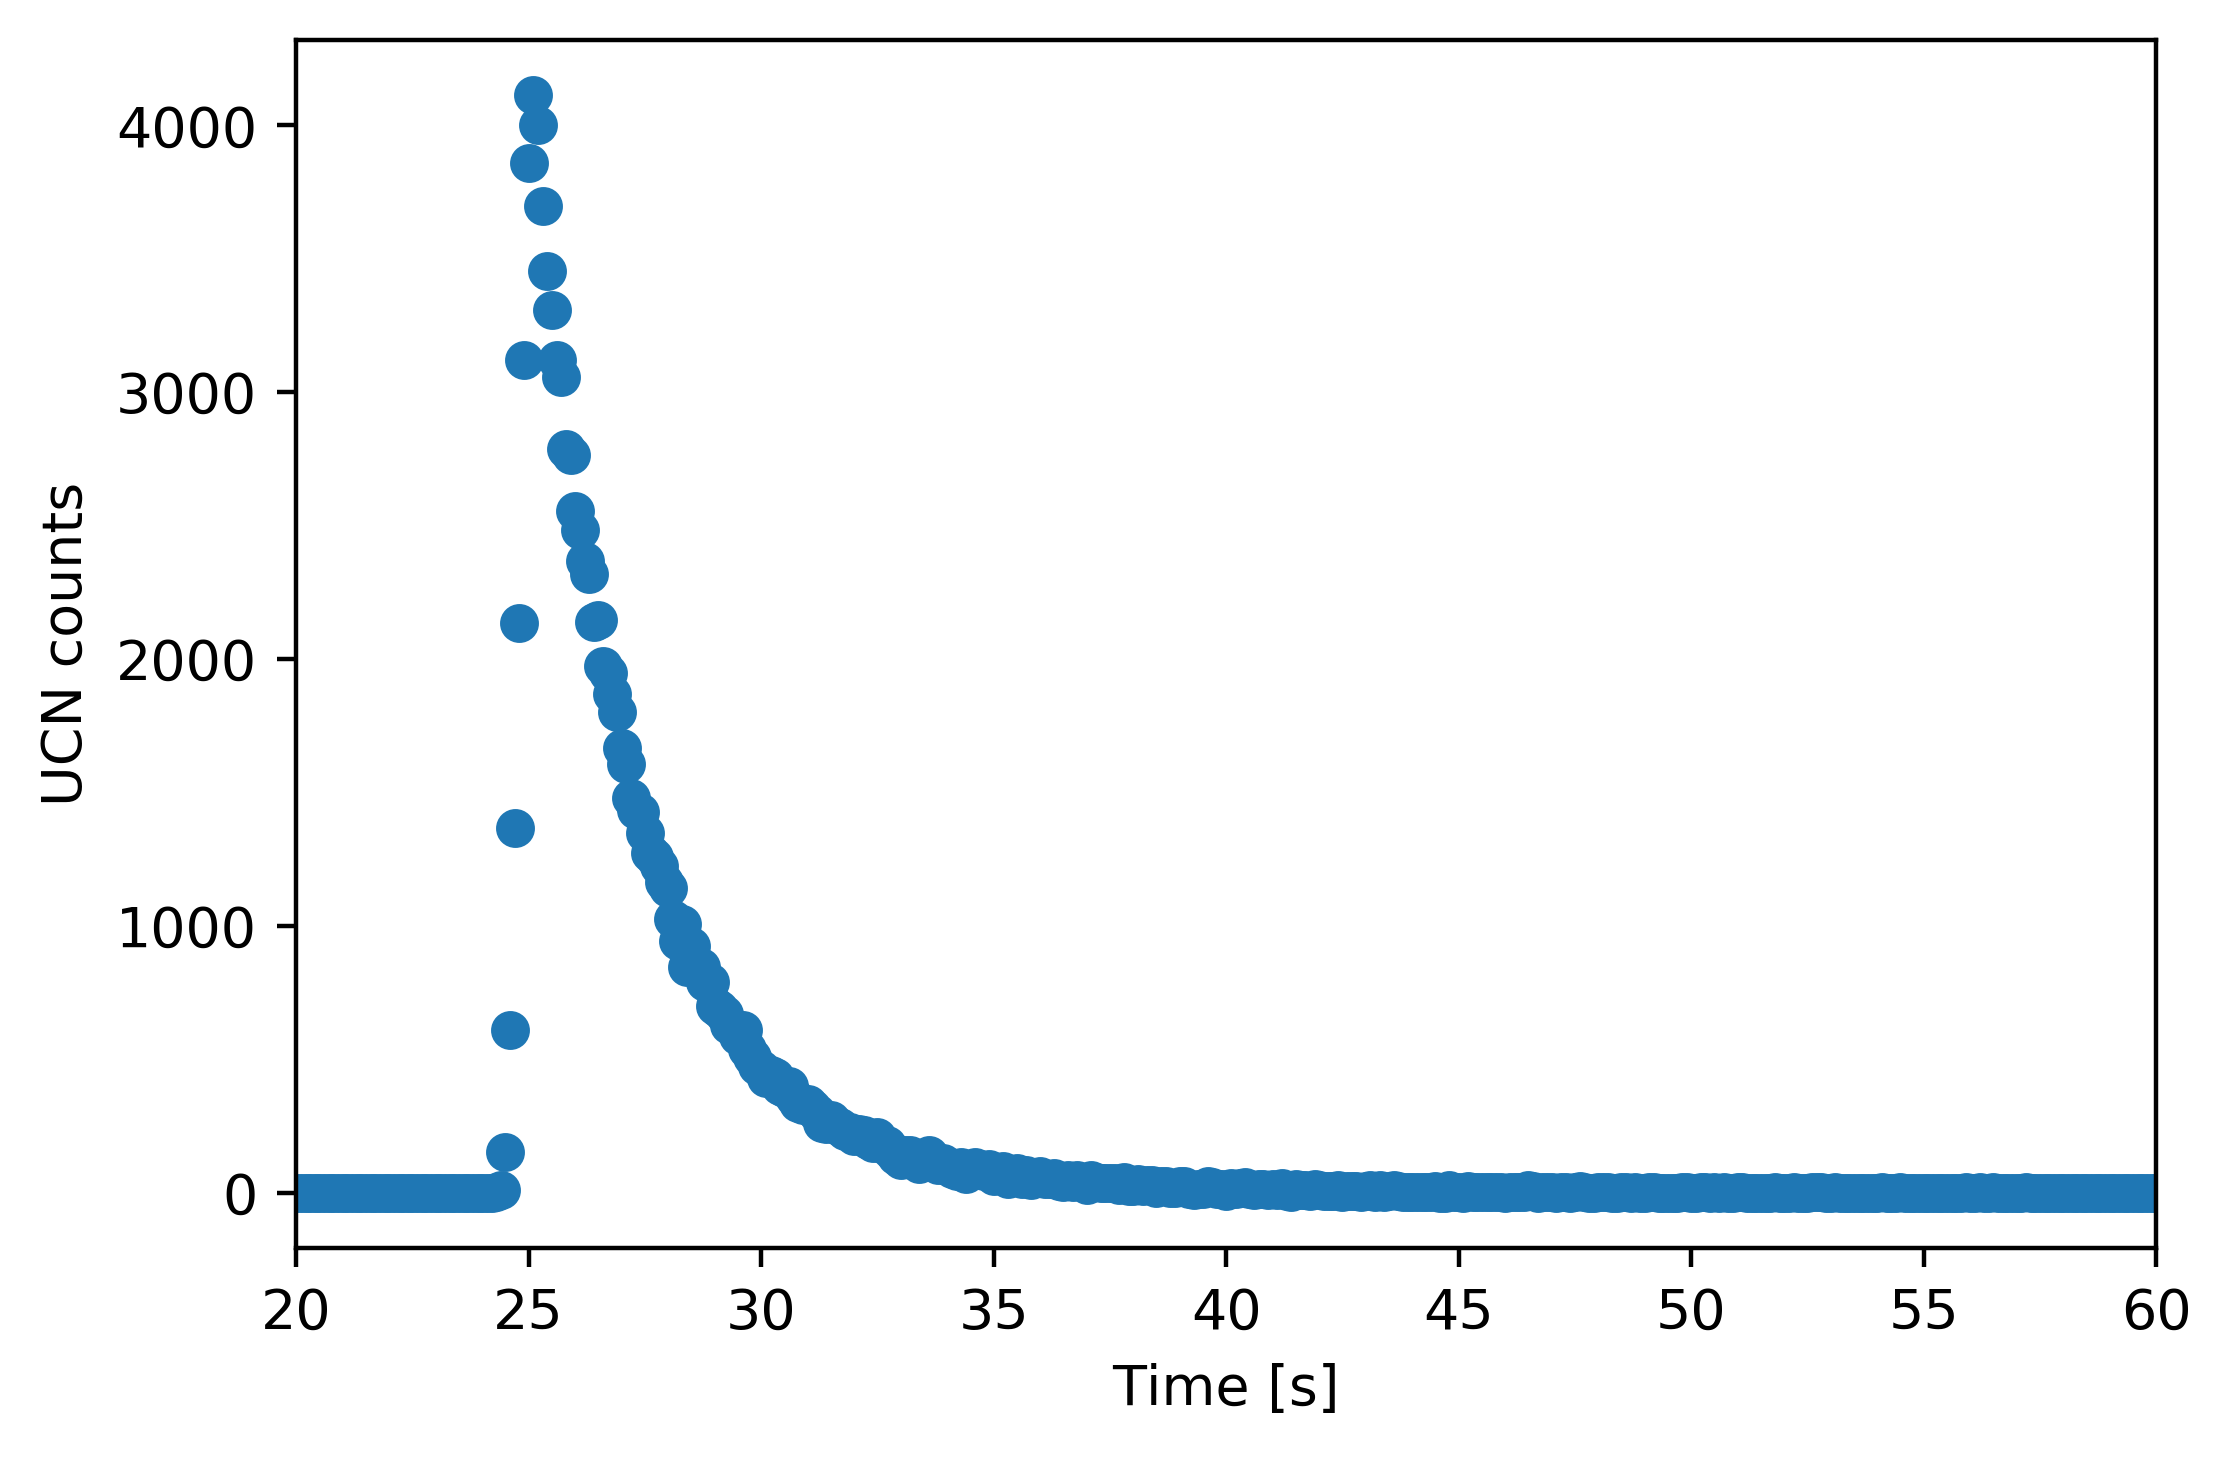

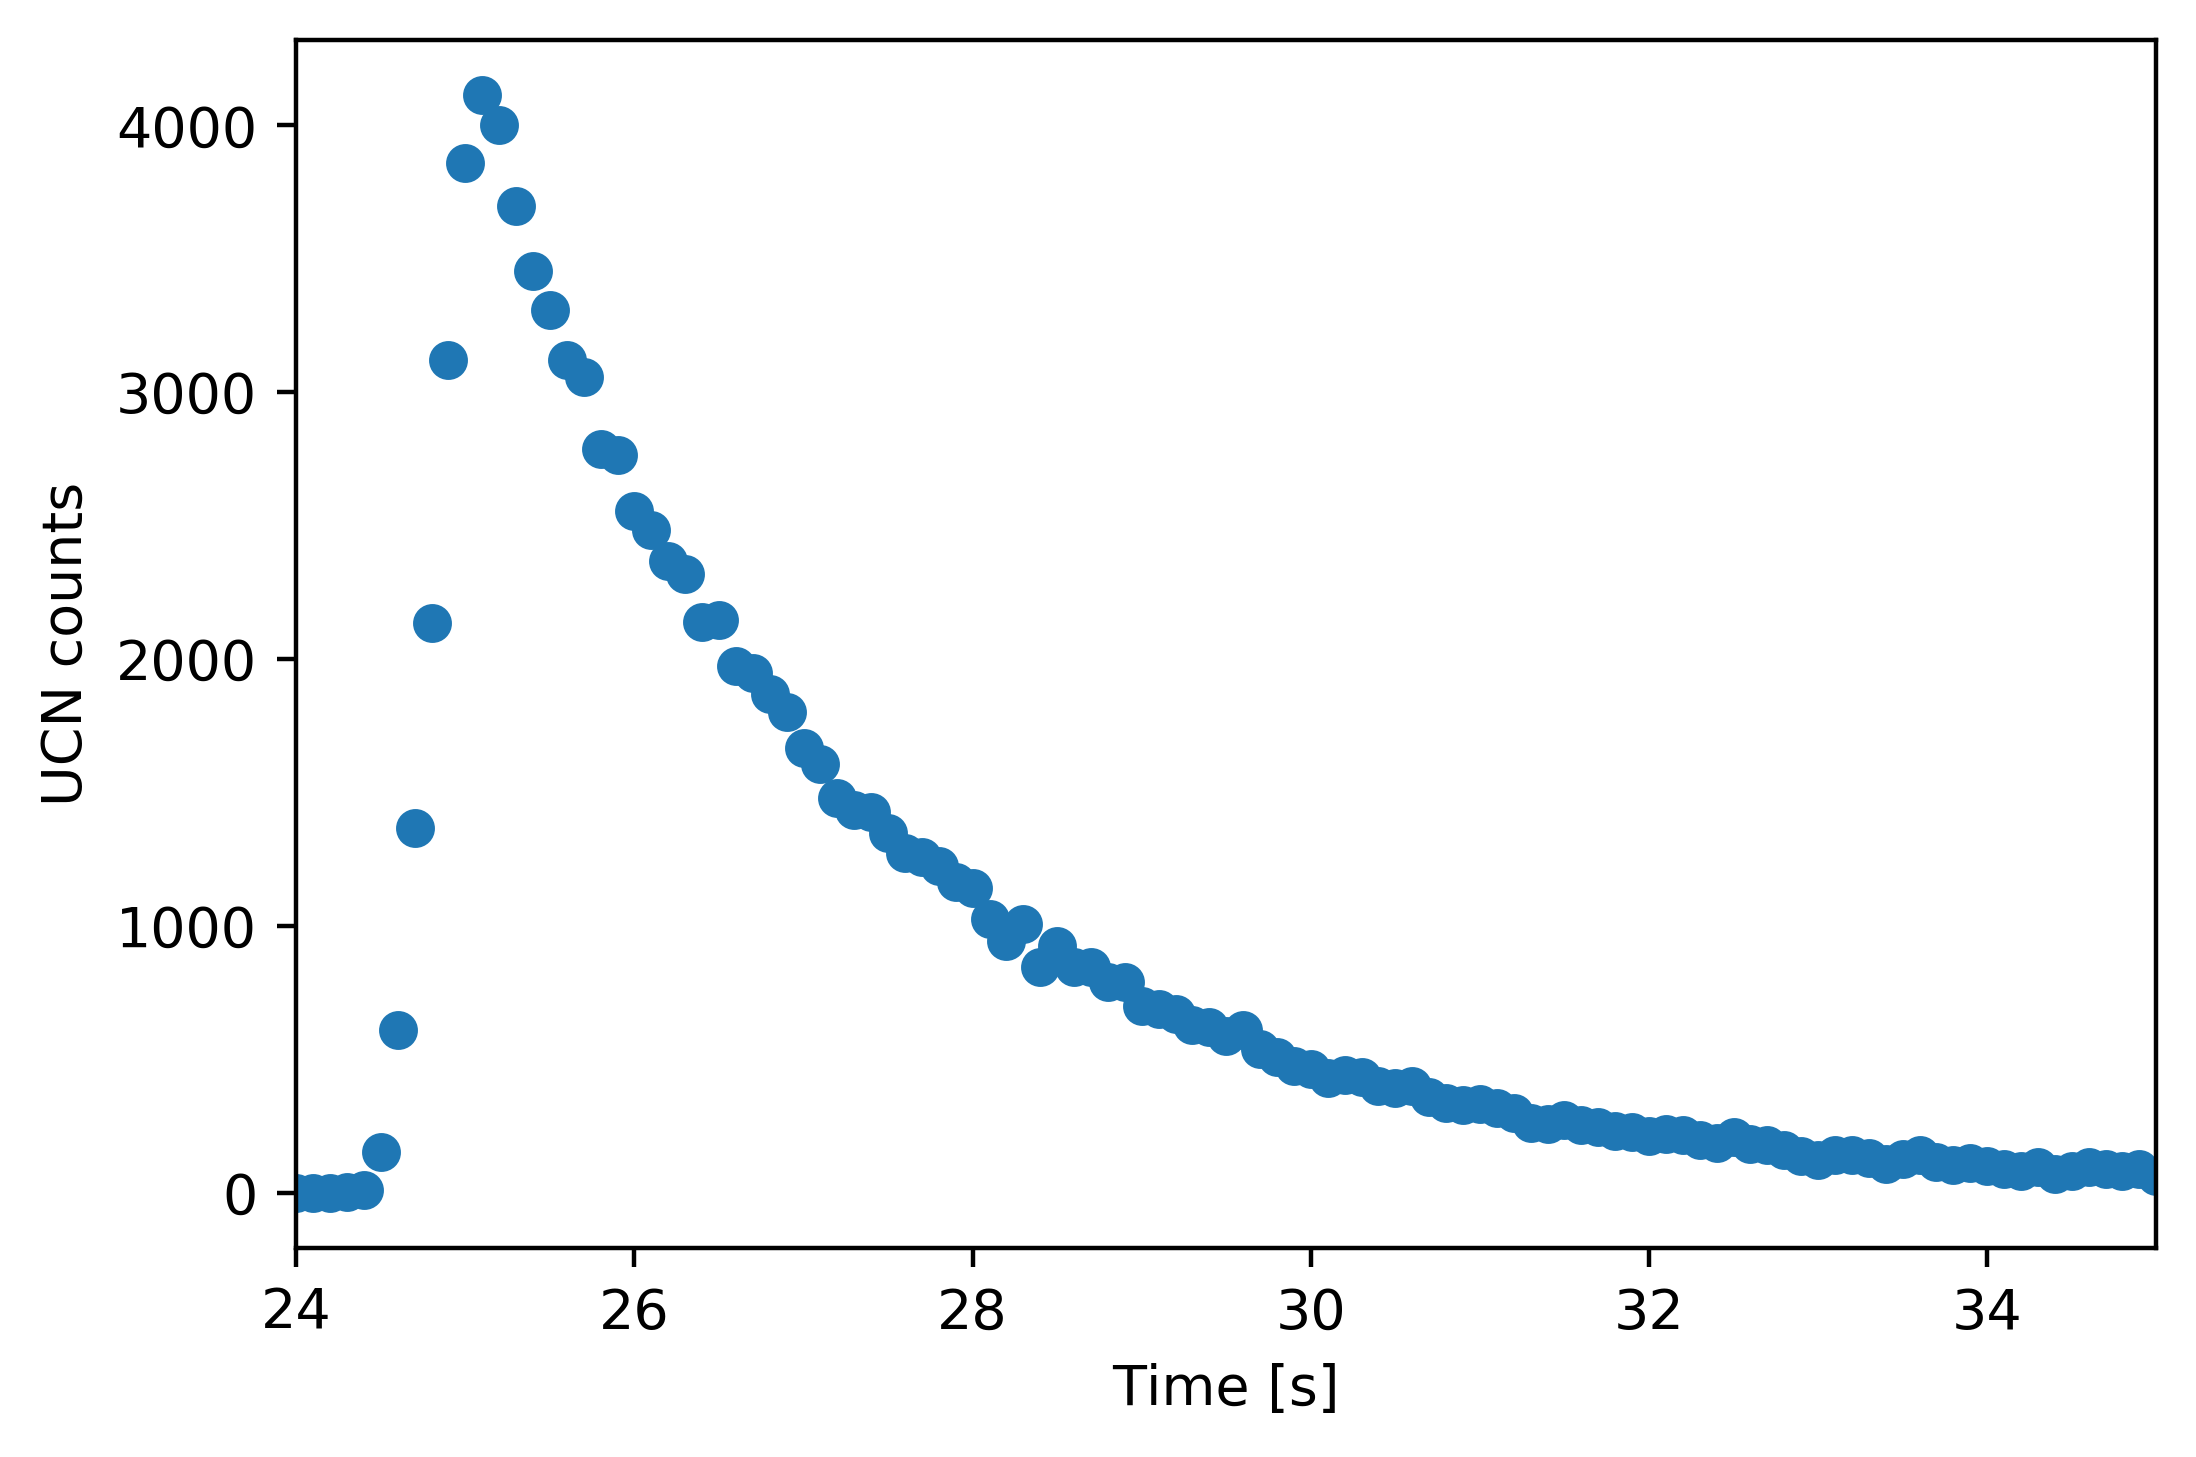

In [8]:
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()

data = np.loadtxt("../data_ucn/main_detector/8/T081217_0034.tof", usecols = (0,1));
ax1.scatter(data[:,0] * 0.1, data[:,1]);
ax1.set_ylabel('UCN counts');
ax1.set_xlabel('Time [s]');

ax2.scatter(data[:,0] * 0.1, data[:,1]);
ax2.set_ylabel('UCN counts');
ax2.set_xlim([20,60])
ax2.set_xlabel('Time [s]');

ax3.scatter(data[:,0] * 0.1, data[:,1]);
ax3.set_ylabel('UCN counts');
ax3.set_xlim([24,35])
ax3.set_xlabel('Time [s]');

# Normalization Configurations

It is not yet clear whether or not the guided measurements will be sensitive to changes in the diffuse reflection probabilities of the guides themselves. 